In [1]:
import sys
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
from tqdm import tqdm
from tqdm import trange

import reconstruct as rec

sys.path.append('/Users/46h/Research/')
from accphys.tools import utils
from accphys.tools import plotting as myplt
from accphys.tools.utils import rotation_matrix

In [2]:
pplt.rc['axes.grid'] = False
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

savefig_kws = dict(dpi=300)

In [3]:
labels = ["x", "x'", "y", "y'"]
labels_norm = [r"$x_n$", r"$x'_n$", r"$y_n$", r"$y'_n$"]

# Tomographic reconstruction in four dimensions 

Tomographic reconstruction — the reconstruction of an image from projections — is a well-developed area of image processing. The most well-known application is in medical imaging, in which the goal is to reconstruct a 3D image of the human body.

An image can be thought of as a *distribution* $f(\mathbf{x})$ which gives the density at point $\mathbf{x}$. A projection of a distribution is a sum along some direction; for example, a 1D projection $f(x)$ of the 2D distribution $f(x, y)$ is

$$
f(x) = \int_{-\infty}^{\infty}{f(x, y)dy}.
$$

When modeling a beam in accelerator, it's important to know the distribution of particles in phase space — the space of positions $\{x, y, z\}$ and momenta $\{p_x, p_y, p_z\}$. (Here $z$ points along the direction of motion and $x$ and $y$ are in a plane transverse to $z$. We'll ignore the $z$ dimension for now.)

There are a few methods to measure the phase space distribution of a beam. The most direct way is to use one slit to block all particles falling outside of a narrow horizontal region $x \pm \Delta_{x}$, a second slit to select a narrow range of momentum $p_x \pm \Delta_{p_x}$, and so on for $y$ and $yp$. This takes a long time and is invasive because most of the beam is blocked. There are also indirect methods in which the covariance matrix of the distribution is reconstructed multiple 1D projections; these are fast and non-invasive, and in many cases they provide enough information. Finally, there is the in-between method of tomographic reconstruction.

In my current project, we're trying to create a beam in the Spallation Neutron Source (SNS) that has an elliptical shape in the $x$-$y$ plane, a uniform charge density, and a large angular momentum. We'd like to measure the four-dimensional (4D) phase space distribution of this beam, which is composed of approximately $10^{14}$ protons moving at 90% the speed of light. 

A slit-scan is not possible at this energy. The SNS has a number of wire-scanners — devices to measure 1D projections of the beam by sweeping a wire across the beam path. By measuring the projections at different angles and varying the magnet strenghs between the wire-scanners, it's possible to reconstruct the beam covariance matrix. I've implemented this method and used it in recent experiments.

The SNS also has a target imaging system. The Mercury target at the very end of the accelerator is coated with a luminescent material that glows when impacted by the proton beam. This allows us to view an image of the beam on the target. It's recently been shown that a 4D distribution can be reconstructed from multiple 2D projections of the beam on a screen under certain conditions, and there are more general methods that can reconstruct the distribution with arbitrary view angles. 

## 2D reconstruction

If we reconstruct in normalized phase space, the transfer matrices between reconstruction and measurement point reduce to rotations in $x$-$x'$ space.

Create the distribution.

In [4]:
dx = 2.0
X = np.vstack([
    np.random.multivariate_normal(mean=[0.0, 0.0], cov=[[2.0, 0.4], [0.4, 1.]], size=100000),
    np.random.normal(loc=[-dx, -dx], scale=[1.0, 1.0], size=(20000, 2)),
    np.random.normal(loc=[dx, dx], scale=[1.0, 1.0], size=(20000, 2)),
    np.random.normal(loc=[dx, -dx], scale=[1.0, 1.0], size=(20000, 2)),
    np.random.normal(loc=[-dx, dx], scale=[1.0, 1.0], size=(20000, 2)),
])

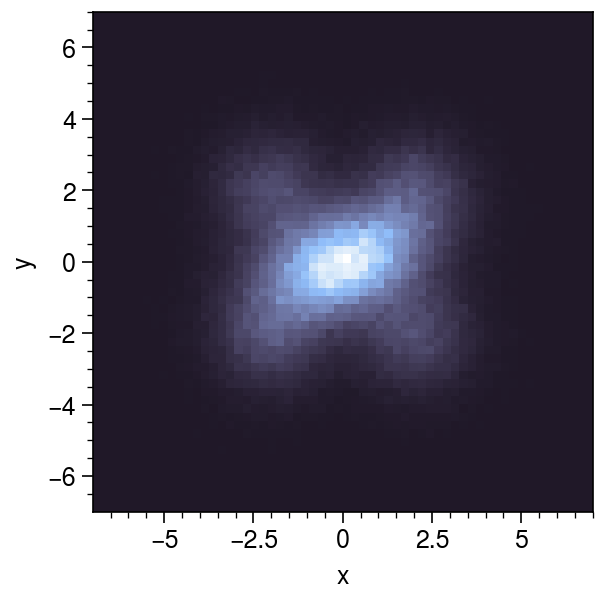

In [5]:
n_bins = 60
limit = (-7.0, 7.0)
bin_area = (np.diff(limit)[0] / n_bins)**2

Z, xedges, yedges = np.histogram2d(X[:, 0], X[:, 1], n_bins, (limit, limit), density=True)
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

fig, ax = pplt.subplots()
ax.pcolormesh(xcenters, ycenters, Z.T, cmap='dusk_r')
ax.format(xlabel="x", ylabel="y")
plt.show()

We now simulate the measurements. The reconstruction and measurement coordinates for measurement $k$ are connected with a transfer matrix $M_k$. In normalized phase space, $M_k$ will rotate the distribution clockwise by angle $\theta_k$ (the phase advance), and we measure the 1D projection of this rotated distribution onto the $x$ axis. This is equivalent to projecting the distribution onto the $s_k$ axis which is rotated counterclockwise relative to the $x$ axis by angle $\theta_k$.

In [6]:
n_proj = 15
angles = np.linspace(0.0, np.pi, n_proj, endpoint=False)
transfer_matrices = [rotation_matrix(angle) for angle in angles]

projections = np.zeros((n_bins, n_proj))
for k in trange(n_proj):
    M = transfer_matrices[k]
    X_meas = np.apply_along_axis(lambda row: np.matmul(M, row), 1, X)
    projections[:, k], _ = np.histogram(X_meas[:, 0], n_bins, limit, density=True)

100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


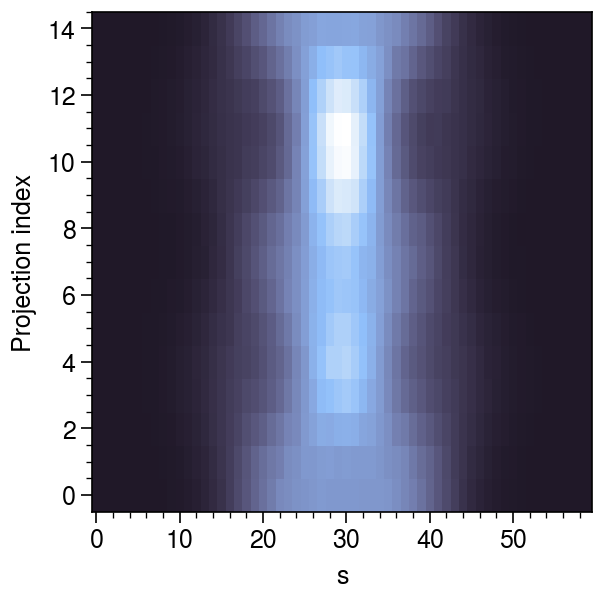

In [7]:
fig, ax = pplt.subplots()
ax.pcolormesh(projections.T, cmap='dusk_r')
ax.format(xlabel='s', ylabel='Projection index')

### Filtered Back-Projection (FPB)

In [8]:
Z_fbp = rec.fbp(projections, angles, keep_positive=True, density=True, limits=(limit, limit))

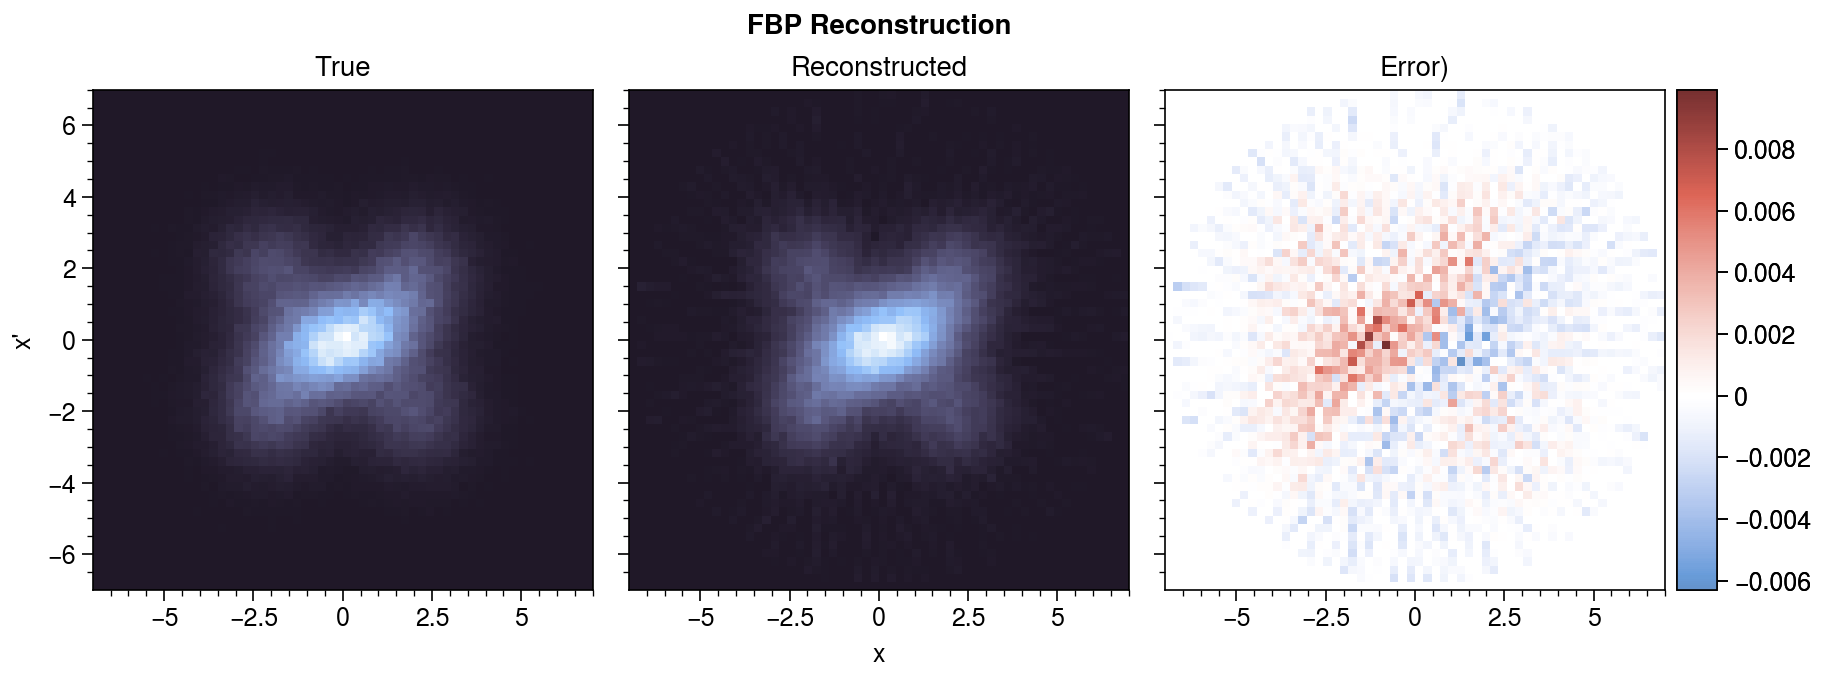

In [9]:
fig, axes = pplt.subplots(ncols=3, figsize=None)
kws = dict(cmap='dusk_r', shading='auto')
axes[0].pcolormesh(xcenters, ycenters, Z.T, **kws)
axes[1].pcolormesh(xcenters, ycenters, Z_fbp.T, **kws)
axes[2].pcolormesh(xcenters, ycenters, (Z - Z_fbp).T, colorbar=True)
axes.format(xlabel="x", ylabel="x'", suptitle='FBP Reconstruction')
axes[0].set_title('True')
axes[1].set_title('Reconstructed');
axes[2].set_title('Error)')
plt.show()

### Simultaneous Algebraic Reconstruction (SART) 

In [10]:
Z_sart = rec.sart(projections, angles, iterations=2, 
                  keep_positive=True, density=True, limits=(limit, limit))

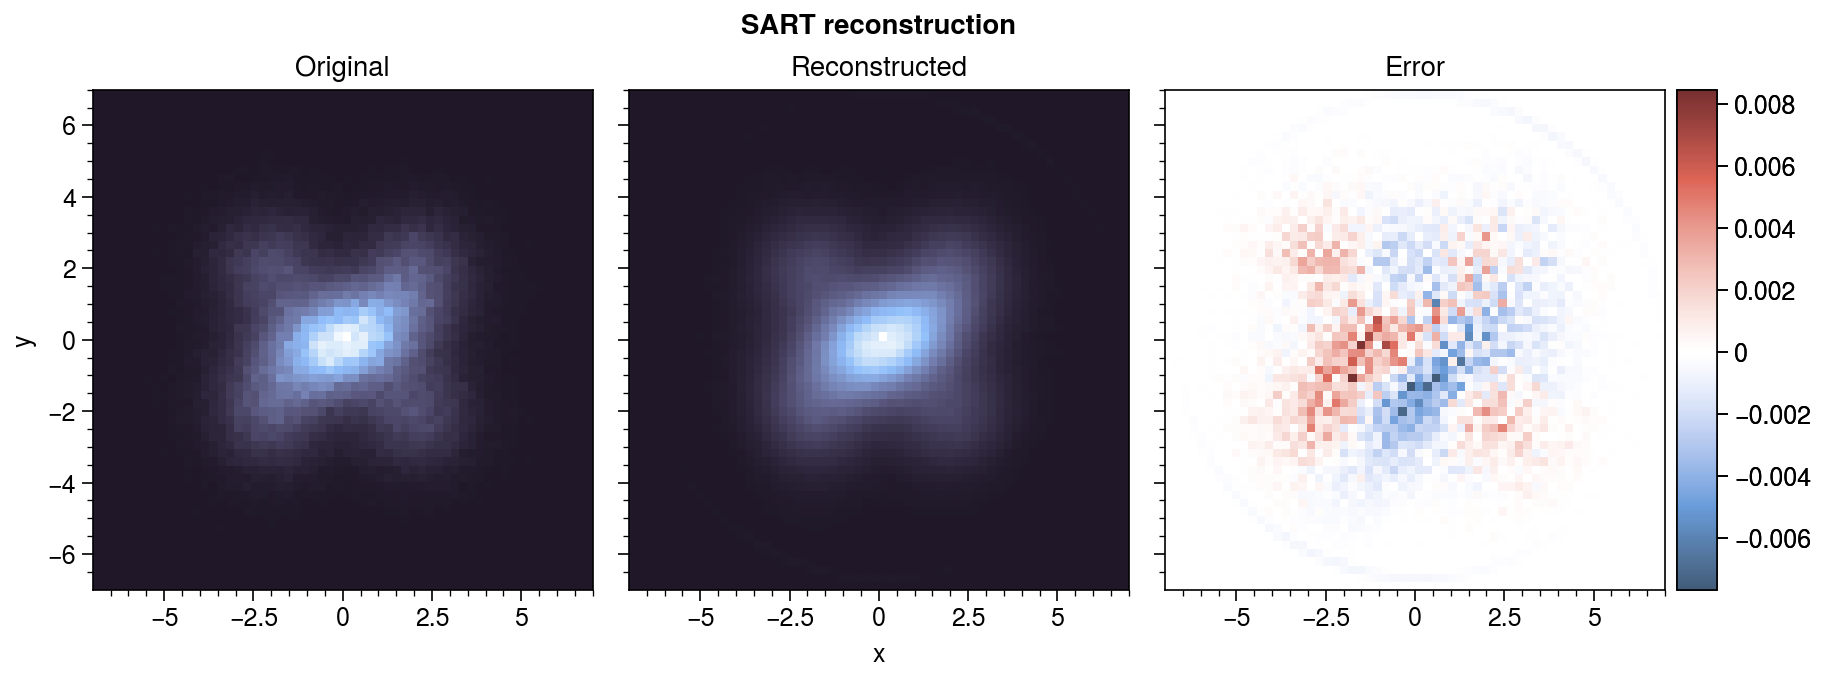

In [11]:
fig, axes = pplt.subplots(ncols=3)
axes[0].pcolormesh(xcenters, ycenters, Z.T, cmap='dusk_r')
axes[1].pcolormesh(xcenters, ycenters, Z_sart.T, cmap='dusk_r')
axes[2].pcolormesh(xcenters, ycenters, (Z - Z_sart).T, colorbar=True)
axes.format(xlabel="x", ylabel="y", suptitle='SART reconstruction')
axes[0].set_title('Original')
axes[1].set_title('Reconstructed')
axes[2].set_title('Error')
plt.show()

### MENT

## 4D phase space reconstruction 

Following method detailed in Hock et. al. (2013).

In [12]:
n_bins = 50

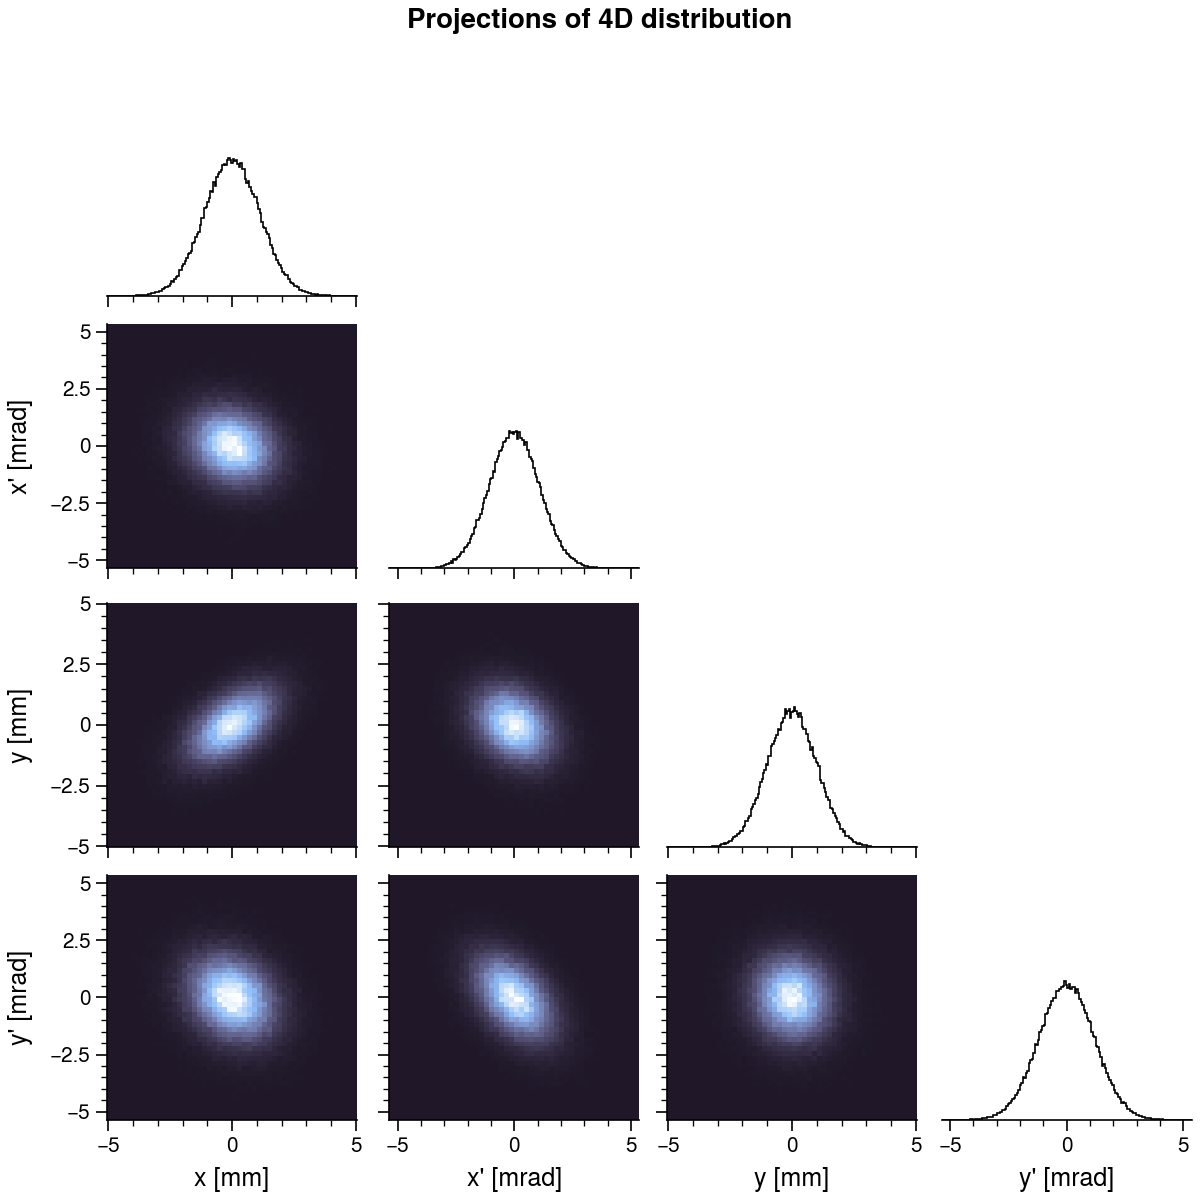

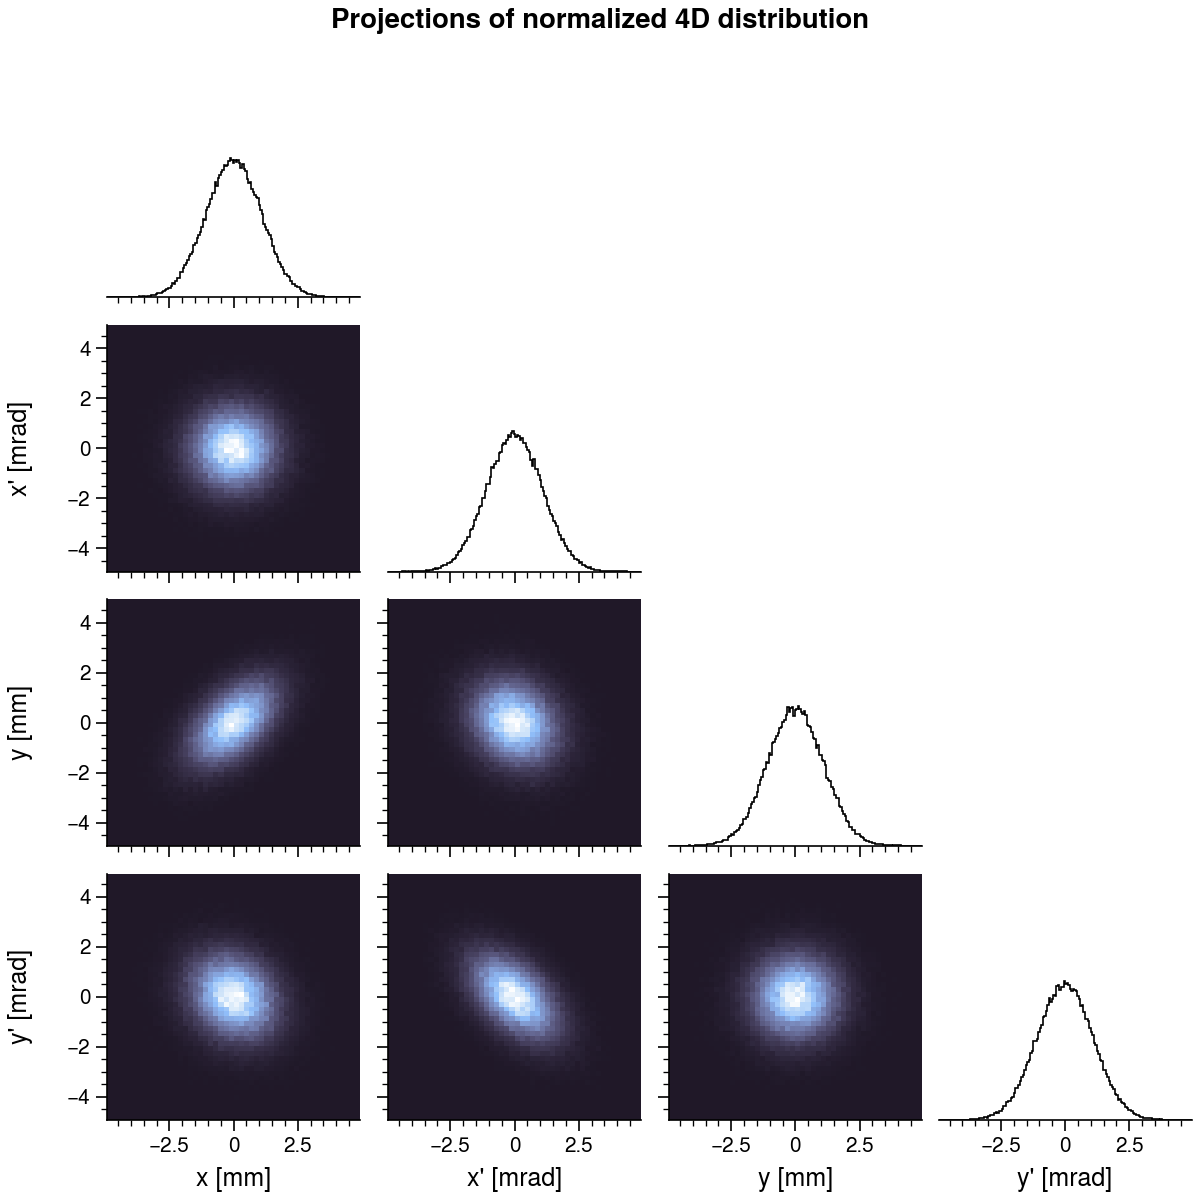

In [13]:
from accphys.tools.accphys_utils import V_matrix_4x4_uncoupled
from accphys.tools.beam_analysis import twiss2D

# Create 4D Gaussian distribution.
X = np.random.normal(size=(125000, 4))

# Add some coupling.
a, b, c = 0.5, 0.1, -0.4
d = b * c / a if a != 0. else 0.
V = np.array([[1., 0., a, b],
              [0., 1., c, d],
              [-d, b, 1., 0],
              [c, -a, 0., 1.]])
X = utils.apply(V, X)

# Normalize x-x' and y-y'.
V = V_matrix_4x4_uncoupled(*twiss2D(np.cov(X.T)))
Xn = utils.apply(np.linalg.inv(V), X)

# Plot the 2D projections of the distribution.
limits_kws = dict(zero_center=True, sigma=4.5)

limits = myplt.auto_limits(X, **limits_kws)
axes = myplt.corner(X, figsize=(6, 6), limits=limits, bins=n_bins)
plt.suptitle('Projections of 4D distribution')
plt.show()

limits = myplt.auto_limits(Xn, **limits_kws)
axes = myplt.corner(Xn, figsize=(6, 6), limits=limits, bins=n_bins)
plt.suptitle('Projections of normalized 4D distribution')
plt.show()

Compute the 4D histogram of the coordinates.

In [14]:
Ztrue, edges = np.histogramdd(Xn, n_bins, limits, density=True)

centers = []
for _edges in edges:
    centers.append(0.5 * (_edges[:-1] + _edges[1:]))

bin_widths = [(np.diff(limit)[0] / n_bins) for limit in limits]
bin_volume = np.prod(bin_widths)

Simulate the measurements. $S_{ijkl}$ gives the density at point $(x_i, y_j)$, on the screen for phase advances (angle) $\theta_{x_k} = \pi k / K$ and $\theta_{y_l} = \pi l / L$. . Since there is no problem, we can just rotate each phase plane separately, then loop through and compute the histograms.

In [ ]:
K = 100 # number of angles in x dimension
L = 100 # number of angles in y dimension

muxx = np.linspace(0., np.pi, K, endpoint=True)
xx_list = []
for mux in tqdm(muxx):
    Mx = rotation_matrix(mux)
    xx_list.append(utils.apply(Mx, X[:, :2])[:, 0])
    
muyy = np.linspace(0., np.pi, K, endpoint=True)
yy_list = []
for muy in tqdm(muyy):
    My = rotation_matrix(muy)
    yy_list.append(utils.apply(My, X[:, 2:])[:, 0])
    
S = np.zeros((n_bins, n_bins, K, L))
for k, xx in enumerate(tqdm(xx_list)):
    for l, yy in enumerate(yy_list):
        S[:, :, k, l], _, _ = np.histogram2d(xx, yy, n_bins, (limits[0], limits[2]))

 18%|█▊        | 18/100 [00:08<00:38,  2.14it/s]

In [ ]:
method = 'FBP' # {'SART', 'FBP', 'MENT'}
kws = dict()
Z = rec.rec4D(S, muxx, muyy, n_bins, method=method, 
              keep_positive=True, density=True, limits=limits, **kws)

In [ ]:
print('min(Z) = {}'.format(np.min(Z)))
print('sum(Z) * bin_volume = {}'.format(np.sum(Z) * bin_volume))
print()
print('min(Ztrue) = {}'.format(np.min(Ztrue)))
print('sum(Ztrue) * bin_volume = {}'.format(np.sum(Ztrue) * bin_volume))

### Accuracy

In [ ]:
fig, axes = pplt.subplots(ncols=4, figsize=(6, 2), spanx=False)

for i in range(4):
    axes[i].plot(centers[i], rec.project(Z, i), color='black', label='Reconstructed')
    axes[i].plot(centers[i], rec.project(Ztrue, i), color='red8', ls='--', label='True')
    axes[i].set_xlabel(labels_norm[i])
axes[0].legend(loc=(0.0, 1.02), framealpha=0.0, ncol=1)
plt.savefig('_output/projections1D.png', **savefig_kws)

In [ ]:
fig, axes = pplt.subplots(nrows=3, ncols=6, figsize=(8, 4), sharex=False, sharey=False)

indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
pcolormesh_kws = dict(cmap='dusk_r')

for col, (i, j) in enumerate(indices):
    axes[0, col].set_title('{}-{}'.format(labels_norm[i], labels_norm[j]))
    Htrue = rec.project(Ztrue, [i, j])
    H = rec.project(Z, [i, j])
    axes[0, col].pcolormesh(centers[i], centers[j], H.T, cmap='dusk_r')
    axes[1, col].pcolormesh(centers[i], centers[j], Htrue.T, cmap='dusk_r')
    axes[2, col].pcolormesh(centers[i], centers[j], (H - Htrue).T)
axes.format(rowlabels=['Reconstructed', 'True', 'Error'], xticks=[], yticks=[])
plt.savefig('_output/projections2D.png', **savefig_kws)

In [ ]:
# def get_projections(Z):
#     """Return list of shape (3, 3)"""
#     projections = [[], [], []]
#     for i in range(3):
#         for j in range(i + 1):
#             projection = project(Z, [j, i + 1])
#             projections[i].append(projection)
#     return projections

# def plot_projections(projections, limits):
#     pcolormesh_kws = dict(cmap='dusk_r', shading='auto')
#     labels = ["x", "x'", "y", "y'"]
#     fig, axes = myplt.pair_grid_nodiag(4, limits=limits)
#     for i in range(3):
#         for j in range(i + 1):
#             ax = axes[i, j]
#             Z = projections[i][j]
#             xlim, ylim = ax.get_xlim(), ax.get_ylim()
#             xx = np.linspace(xlim[0], xlim[1], Z.shape[0])
#             yy = np.linspace(ylim[0], ylim[1], Z.shape[1])
#             ax.pcolormesh(xx, yy, Z.T, **pcolormesh_kws)
#     return axes

# projections = get_projections(F_true)
# axes = plot_projections(projections, limits)
# plt.suptitle('Reconstructed')

# projections_err = get_projections(np.abs(F - F_true))
# axes = plot_projections(projections_err, limits)
# plt.suptitle('abs(error)');

In [ ]:
error = np.sum((Z - Ztrue)**2)
print('SSQ error = {}'.format(error))